In [246]:
%matplotlib qt

In [245]:
%matplotlib notebook
%matplotlib inline
%autosave 120

Autosaving every 120 seconds


In [2]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from microsim.bp_treatment_strategies import *

from microsim.outcome_model_repository import OutcomeModelRepository
from microsim.outcome_model_type import OutcomeModelType
from microsim.person import Person

from microsim.population import NHANESDirectSamplePopulation

from microsim.bp_treatment_strategies import SprintTreatment

from microsim.sim_settings import simSettings

from microsim.trials.trialset import TrialsetParallel, TrialsetSerial
from microsim.trials.trial_description import TrialDescription
from microsim.trials.logistic_regression_analysis import LogisticRegressionAnalysis
from microsim.trials.linear_regression_analysis import LinearRegressionAnalysis
from microsim.trials.outcome_assessor import OutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AttributeOutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AssessmentMethod
from microsim.trials.risk_filter import RiskFilter
from microsim.trials.trial_utils import get_analysis_name, randomizationSchema

In [4]:
#any microsim dir will work, just need to access the NHANES data
#microsimDir = "/users/PAS2164/deligkaris/MICROSIM/CODE/microsim"
microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)
imputedDataset = pd.read_stata(microsimDir + "/microsim/data/fullyImputedDataset.dta")

In [5]:
#at the beginning turn on pandarallel if you are planning to use TrialsetSerial
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

In [6]:
%%time
#with pandarallel on these two steps are faster
#12min with 10,000, 22min with 20,000, 61min with 60,000, 102min with 100,000
#osc: 27min with 10,000
pop = NHANESDirectSamplePopulation(60000, 1999)
alive, df = pop.advance_vectorized(200)

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold)

/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age


CPU times: user 45min 47s, sys: 3min 58s, total: 49min 45s
Wall time: 1h 2s


In [7]:
def getDFForPersonCol(person):
    df = pd.DataFrame(person.get_final_wave_state_as_dict())
    df['dfIndex'] = person.dfIndex
    df['cvRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person, args=(OutcomeModelType.CARDIOVASCULAR, 1, True), axis='columns')
    df['demRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person,  args=(OutcomeModelType.DEMENTIA, 1, True), axis='columns')
    return df

dfs = pop._people.apply(getDFForPersonCol)

In [319]:
allAgesDF = pd.concat(dfs.tolist())

In [320]:
#allAgesDF.head()

In [321]:
#allAgesDF = allAgesDF.loc[allAgesDF.totalYearsInSim == 1]

In [322]:
#allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk'].count(), allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk']

In [323]:
allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk'] = 1

In [324]:
#allAgesDF.demRisk.describe(), allAgesDF.cvRisk.describe()

In [325]:
#if some points are outside of the min and max of this then qcut will return them to belong in NaN
#np.arange(increment, 1.0, increment)

In [326]:
#we need to have n+1 points in order to have n intervals
#len(np.arange(increment, 1.0, increment)),len(np.arange(0, 1.0, increment)),len(np.arange(0, 1.0+increment, increment))

In [327]:
nQuantiles = 20
increment = 1.0/nQuantiles
#qcut will move the left boundary to a value lower than the min, so that the left end (which is open)
#will include the min
allAgesDF['demRiskQuantile'] = pd.qcut(allAgesDF.demRisk, np.arange(0, 1.0+increment, increment))
allAgesDF['cvRiskQuantile'] = pd.qcut(allAgesDF.cvRisk, np.arange(0, 1.0+increment, increment))

In [328]:
#allAgesDF.shape

In [329]:
#allAgesDF['cvRiskQuantile'].head(50)

In [330]:
#there should not be any NaNs
allAgesDF['demRiskQuantile'].isna().sum(), allAgesDF['cvRiskQuantile'].isna().sum()

(0, 0)

In [331]:
#allAgesDF['demRiskQuantile'].head()

In [332]:
meanDemRiskForQuantile = allAgesDF.groupby('demRiskQuantile')['demRisk'].mean()
meanCVRiskForQuantile = allAgesDF.groupby('cvRiskQuantile')['demRisk'].mean()
meanDemRiskForQuantileDict = {index : value for index, value in meanDemRiskForQuantile.items()}
meanCVRiskForQuantileDict = {index : value for index, value in meanCVRiskForQuantile.items()}
demQuantileNumberForQuantile = {quantile : index for index, quantile in enumerate(allAgesDF['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileNumberForQuantile = {quantile : index for index, quantile in enumerate(allAgesDF['cvRiskQuantile'].value_counts(sort=False).index)}
demQuantileForNumber = {index : quantile for index, quantile in enumerate(allAgesDF['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileForNumber = {index : quantile for index, quantile in enumerate(allAgesDF['cvRiskQuantile'].value_counts(sort=False).index)}

In [333]:
allAgesDF['cvRiskQuantile'].value_counts(sort=False).index

CategoricalIndex([(-0.00099882, 0.000129],    (0.000129, 0.000304],
                     (0.000304, 0.000535],    (0.000535, 0.000821],
                      (0.000821, 0.00116],      (0.00116, 0.00157],
                       (0.00157, 0.00206],      (0.00206, 0.00263],
                        (0.00263, 0.0033],       (0.0033, 0.00409],
                       (0.00409, 0.00502],      (0.00502, 0.00611],
                       (0.00611, 0.00742],        (0.00742, 0.009],
                          (0.009, 0.0109],        (0.0109, 0.0133],
                         (0.0133, 0.0163],        (0.0163, 0.0205],
                         (0.0205, 0.0275],        (0.0275, 0.0929]],
                 categories=[(-0.00099882, 0.000129], (0.000129, 0.000304], (0.000304, 0.000535], (0.000535, 0.000821], ..., (0.0133, 0.0163], (0.0163, 0.0205], (0.0205, 0.0275], (0.0275, 0.0929]], ordered=True, dtype='category')

In [334]:
demQuantileNumberForQuantile

{Interval(-0.0009999539, 1.27e-05, closed='right'): 0,
 Interval(1.27e-05, 4.03e-05, closed='right'): 1,
 Interval(4.03e-05, 9.49e-05, closed='right'): 2,
 Interval(9.49e-05, 0.000185, closed='right'): 3,
 Interval(0.000185, 0.000325, closed='right'): 4,
 Interval(0.000325, 0.000536, closed='right'): 5,
 Interval(0.000536, 0.000843, closed='right'): 6,
 Interval(0.000843, 0.00129, closed='right'): 7,
 Interval(0.00129, 0.00191, closed='right'): 8,
 Interval(0.00191, 0.0028, closed='right'): 9,
 Interval(0.0028, 0.00405, closed='right'): 10,
 Interval(0.00405, 0.00582, closed='right'): 11,
 Interval(0.00582, 0.00834, closed='right'): 12,
 Interval(0.00834, 0.012, closed='right'): 13,
 Interval(0.012, 0.0173, closed='right'): 14,
 Interval(0.0173, 0.0255, closed='right'): 15,
 Interval(0.0255, 0.0388, closed='right'): 16,
 Interval(0.0388, 0.0631, closed='right'): 17,
 Interval(0.0631, 0.12, closed='right'): 18,
 Interval(0.12, 1.0, closed='right'): 19}

In [335]:
#allAgesDF['demRiskQuantile'].value_counts().index

In [336]:
#meanDemRiskForQuantile, meanDemRiskForQuantileDict, demQuintileNumberForQuantile

In [337]:
allAgesDF['meanDemRiskForQuantile'] = allAgesDF['demRiskQuantile']
allAgesDF['meanDemRiskForQuantile'].replace(meanDemRiskForQuantileDict, inplace=True)
allAgesDF['meanCVRiskForQuantile'] = allAgesDF['cvRiskQuantile']
allAgesDF['meanCVRiskForQuantile'].replace(meanCVRiskForQuantileDict, inplace=True)

allAgesDF['cvQuantileNum'] = allAgesDF['cvRiskQuantile']
allAgesDF['cvQuantileNum'].replace(cvQuantileNumberForQuantile, inplace=True)

allAgesDF['demQuantileNum'] = allAgesDF['demRiskQuantile']
allAgesDF['demQuantileNum'].replace(demQuantileNumberForQuantile, inplace=True)

In [338]:
#allAgesDF.head()

In [339]:
### next step is to see how this varies by age...
### if we have wide distribution, then we can just go through deciles or something like that for trial sampling!

In [340]:
#allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'])['age'].count()

In [341]:
countByRisks = allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=True
                                )['age'].count().unstack(fill_value=0).stack()
#countByRisks

In [342]:
#countByRisks = allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=False
#                                )['age'].count().unstack(fill_value=0).stack()
#countByRisks

In [343]:
countByRisksDF = pd.DataFrame({'demRisk' : countByRisks.index.get_level_values(0),
                              'cvRisk' : countByRisks.index.get_level_values(1),
                              'ageCount' : countByRisks.values})
countByRisksDF

,demRisk,cvRisk,ageCount
0,0,0,62519
1,0,1,35938
2,0,2,14771
3,0,3,5358
4,0,4,1577
5,0,5,357
6,0,6,59
7,0,7,10
8,0,8,2
9,0,9,1


In [344]:
#allAgesDF['dfIndex'].nunique()

In [345]:
#allAgesDF.loc[(allAgesDF.demQuantileNum==5) & (allAgesDF.cvQuantileNum==5),"dfIndex"]

In [346]:
#allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=False)['dfIndex'].nunique()

In [347]:
#allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=False)['dfIndex'].nunique().unstack(fill_value=0)

In [348]:
countIndexByRisks = allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=False
                                )['dfIndex'].nunique().unstack(fill_value=0).stack()

In [349]:
countIndexByRisksDF = pd.DataFrame({'demRisk' : countIndexByRisks.index.get_level_values(0),
                              'cvRisk' : countIndexByRisks.index.get_level_values(1),
                              'indexCount' : countIndexByRisks.values})
countIndexByRisksDF

,demRisk,cvRisk,indexCount
0,0,0,3663
1,0,1,3175
2,0,2,1210
3,0,3,482
4,0,4,260
5,0,5,123
6,0,6,34
7,0,7,9
8,0,8,1
9,0,9,1


In [350]:
#used in plots later
X=np.arange(0,nQuantiles,1)
Y=np.arange(0,nQuantiles,1)
X, Y = np.meshgrid(X, Y)
X.shape

(20, 20)

In [351]:
#this is done just in case the quantile categories are not ordered properly
countByRisksArray=np.zeros(X.shape)
for i,j,k in zip(countByRisksDF["demRisk"].values,countByRisksDF["cvRisk"].values,countByRisksDF["ageCount"].values):
    countByRisksArray[i,j]=k
#countByRisksArray

In [352]:
#this is done just in case the quantile categories are not ordered properly
countIndexByRisksArray=np.zeros(X.shape)
for i,j,k in zip(countIndexByRisksDF["demRisk"].values,countIndexByRisksDF["cvRisk"].values,countIndexByRisksDF["indexCount"].values):
    countIndexByRisksArray[i,j]=k
#countByRisksArray

In [353]:
ageCountSum = countByRisksDF["ageCount"].sum() #sum of all person-ages
ageCountSumPerQbox = ageCountSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
ageCountSum, ageCountSumPerQbox

(2411836, 6029.59)

In [354]:
percentCutoff = 1. #relevant to a uniform distribution, which qq categories to keep
cutoff = (ageCountSumPerQbox * percentCutoff)
cutoff

6029.59

In [355]:
qqcategoriesToInclude = countByRisksDF.loc[countByRisksDF["ageCount"] > cutoff] 
#qqcategoriesToInclude, 
qqcategoriesToInclude["ageCount"].sum()/ageCountSum #percent of person-ages included

0.8673247268885612

In [356]:
#if demRisk and cvRisk are not ordered correctly, this does not work...
#countByRisksDF['ageCount'].to_numpy().reshape(nQuantiles-0, nQuantiles-0) >5000 

<IPython.core.display.Javascript object>


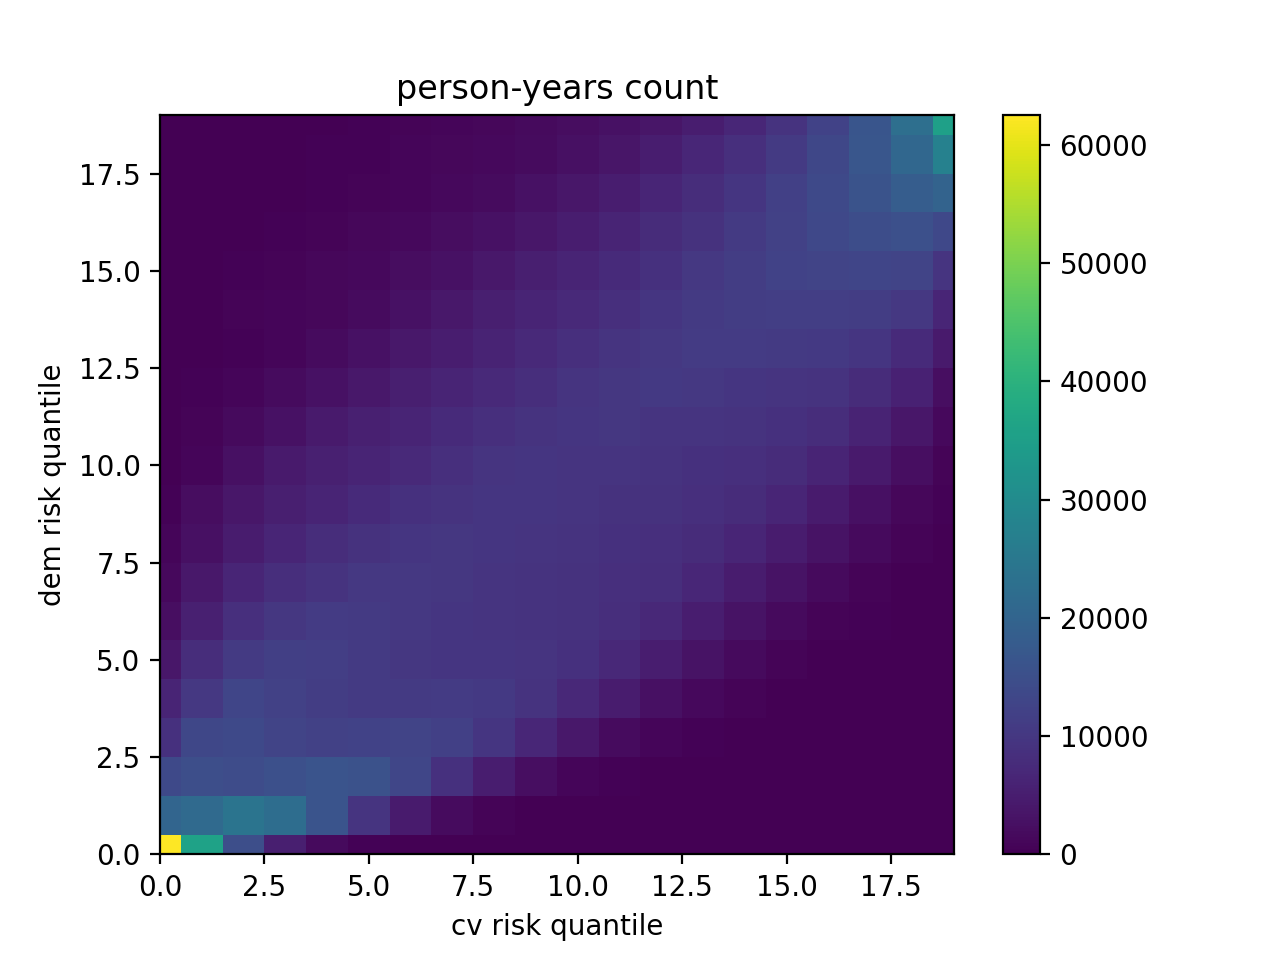

In [357]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByRisksArray, shading='nearest')
ax.set_title('person-years count')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

<IPython.core.display.Javascript object>


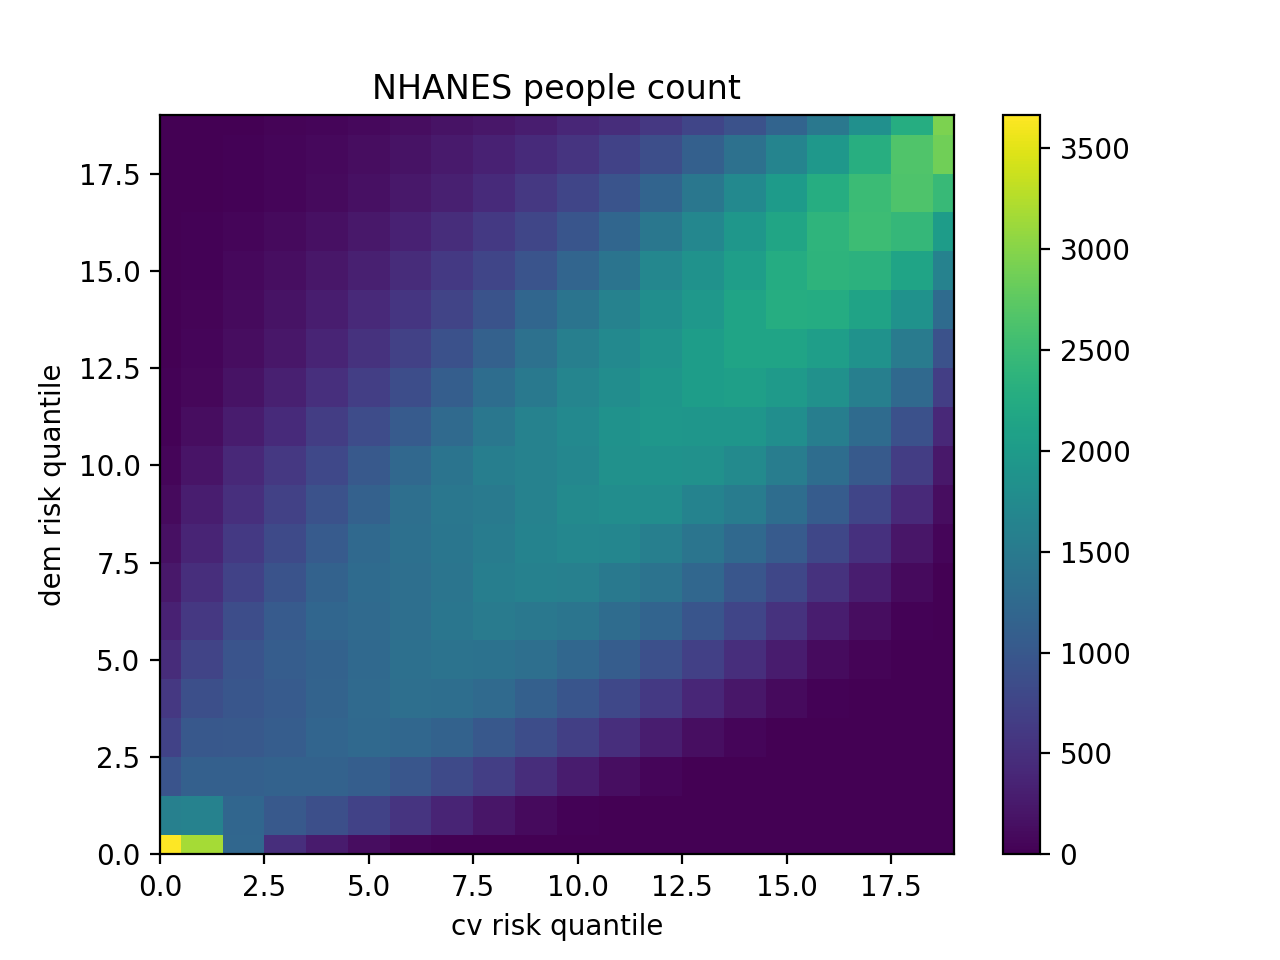

In [358]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countIndexByRisksArray, shading='nearest')
ax.set_title('NHANES people count')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [359]:
# decide on which quantiles to keep
included = np.zeros(X.shape)

for i, j in zip(qqcategoriesToInclude["demRisk"],qqcategoriesToInclude["cvRisk"]):
    included[i,j]=1
    
#included

<IPython.core.display.Javascript object>


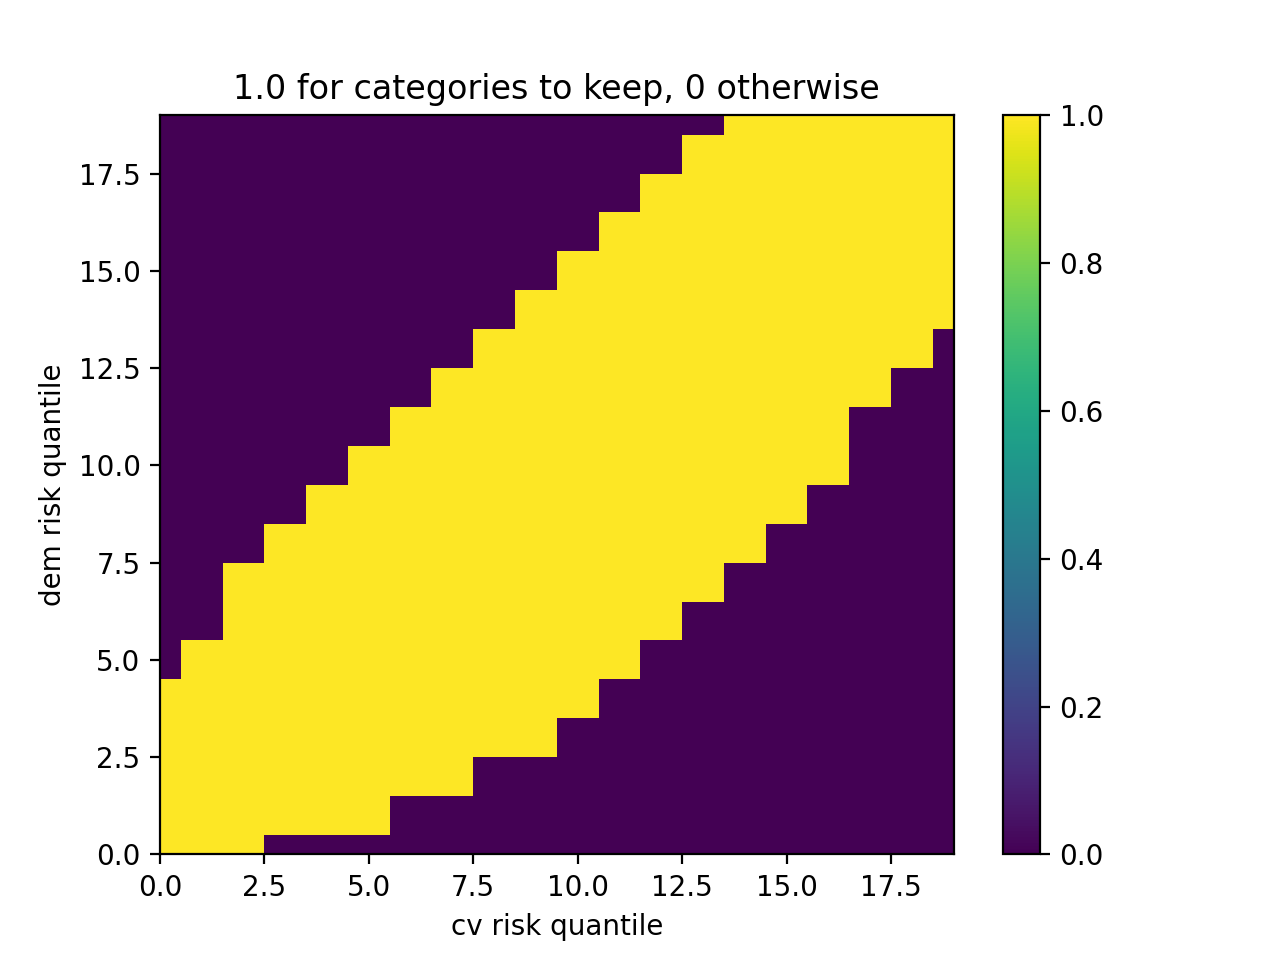

In [360]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, included, shading='nearest')
ax.set_title('1.0 for categories to keep, 0 otherwise')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [239]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [240]:
ax = Axes3D(fig)

<IPython.core.display.Javascript object>


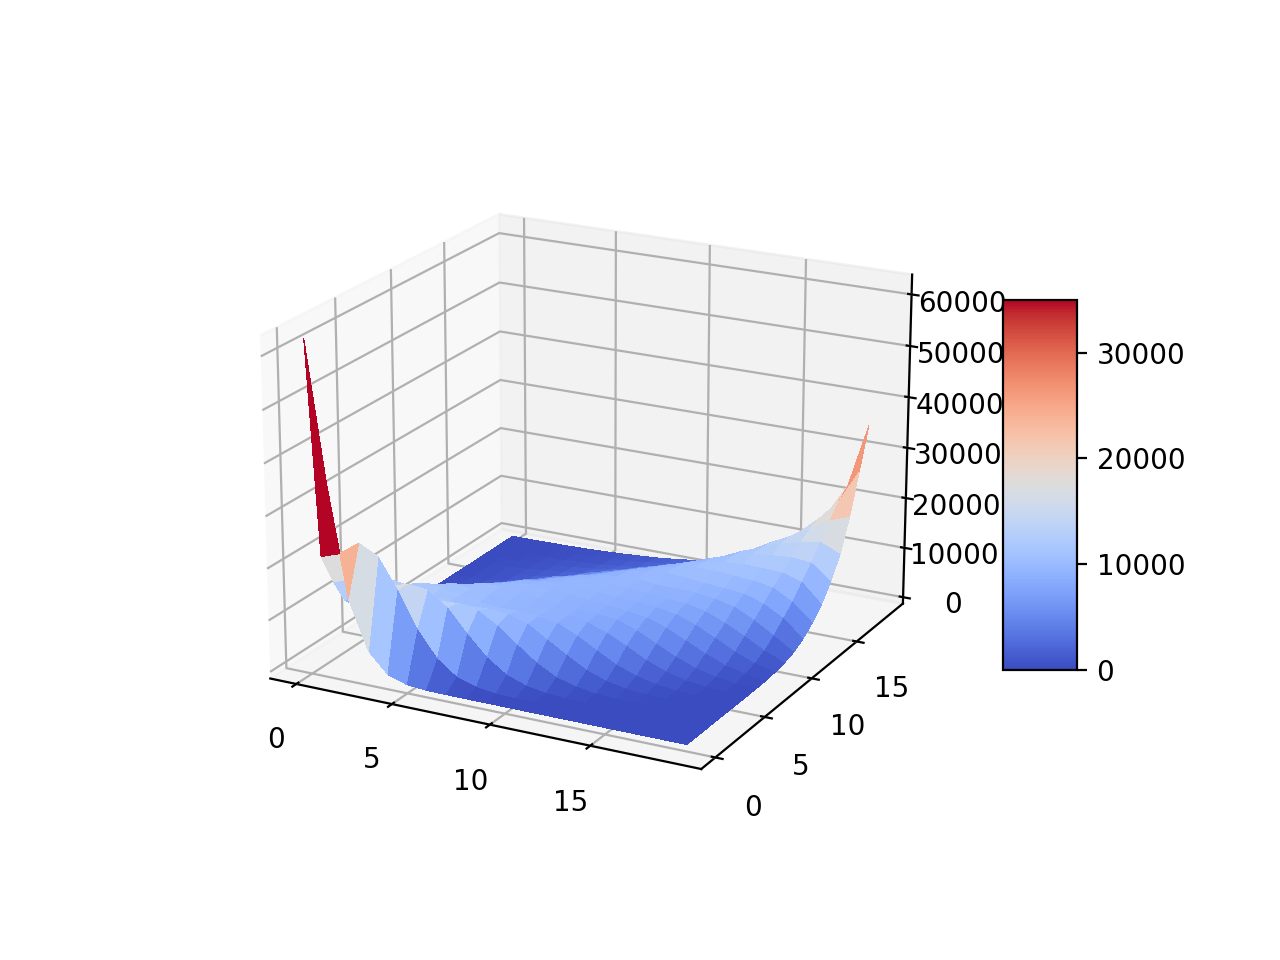

In [361]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, countByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


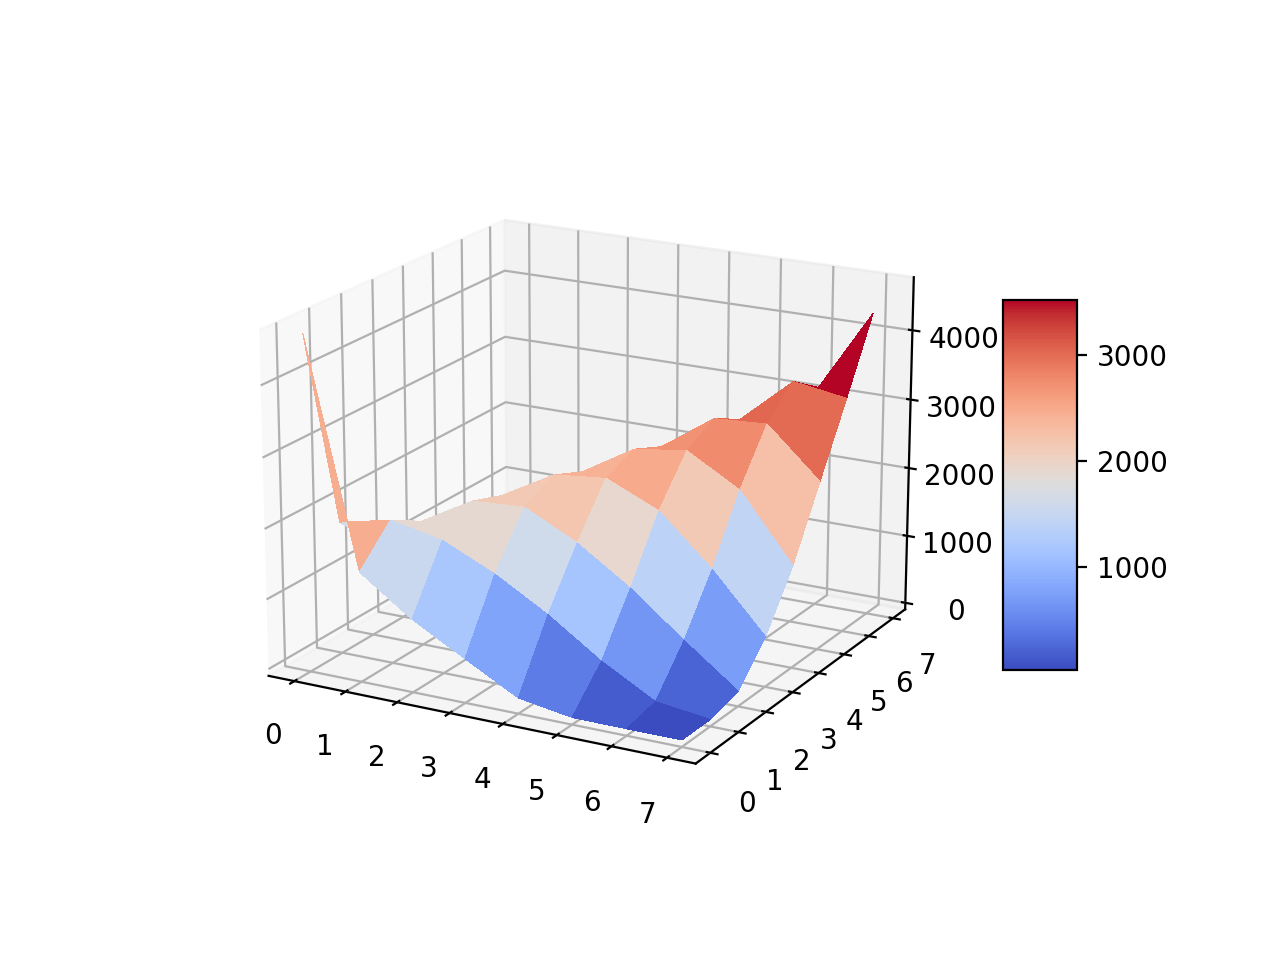

In [312]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, countIndexByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [242]:
from matplotlib.colors import LightSource

<IPython.core.display.Javascript object>


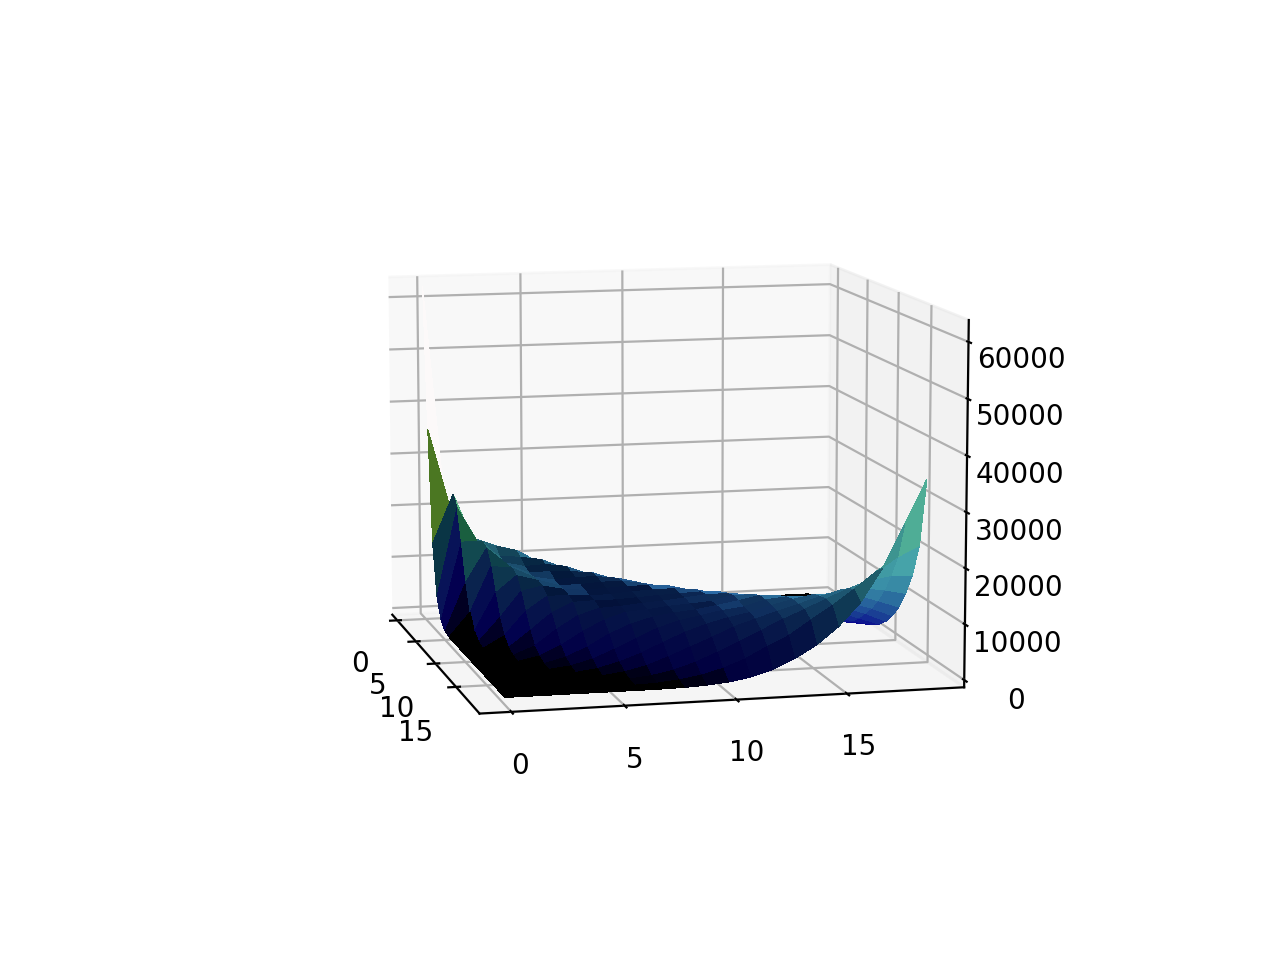

In [362]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(countByRisksArray, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X,Y,countByRisksArray, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

In [313]:
demQuantiles = allAgesDF.demRisk.quantile(np.arange(0, 1+increment, increment).tolist())
cvQuantiles = allAgesDF.cvRisk.quantile(np.arange(0, 1+increment, increment).tolist())
quantileDF = pd.DataFrame(index=demQuantiles.index, data={'dementia' : demQuantiles.values, 'cv' : cvQuantiles.values})
quantileDF.to_csv("~/Desktop/dementiaAndCVQuintileThresholds.csv")
quantileDF

,dementia,cv
0.000,4.610154e-08,0.000001
0.125,6.378081e-05,0.000412
0.250,3.253906e-04,0.001164
0.375,1.044507e-03,0.002329
0.500,2.802279e-03,0.004091
0.625,6.966975e-03,0.006732
0.750,1.731452e-02,0.010908
0.875,4.892885e-02,0.018197
1.000,1.000000e+00,0.092891


In [314]:
allAgesDF.demRisk.describe(), allAgesDF.cvRisk.describe()

(count    2.411836e+06
 mean     2.496206e-02
 std      7.102553e-02
 min      4.610154e-08
 25%      3.253906e-04
 50%      2.802279e-03
 75%      1.731452e-02
 max      1.000000e+00
 Name: demRisk, dtype: float64,
 count    2.411836e+06
 mean     7.744161e-03
 std      9.461083e-03
 min      1.177193e-06
 25%      1.163543e-03
 50%      4.091181e-03
 75%      1.090776e-02
 max      9.289099e-02
 Name: cvRisk, dtype: float64)

In [315]:
qqcategoriesToInclude["demRiskInterval"] = qqcategoriesToInclude["demRisk"].apply(lambda x:demQuantileForNumber[x])
qqcategoriesToInclude["cvRiskInterval"] = qqcategoriesToInclude["cvRisk"].apply(lambda x:cvQuantileForNumber[x])
#countByRisks
#allAgesDF.sample(50)

/var/folders/gw/n7s8sshd3j15_qhx38pz00x40000gq/T/ipykernel_1722/3766872978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqcategoriesToInclude["demRiskInterval"] = qqcategoriesToInclude["demRisk"].apply(lambda x:demQuantileForNumber[x])
/var/folders/gw/n7s8sshd3j15_qhx38pz00x40000gq/T/ipykernel_1722/3766872978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqcategoriesToInclude["cvRiskInterval"] = qqcategoriesToInclude["cvRisk"].apply(lambda x:cvQuantileForNumber[x])


In [316]:
qqcategoriesToInclude

,demRisk,cvRisk,ageCount,demRiskInterval,cvRiskInterval
0,0,0,179655,"(-0.0009999539, 6.38e-05]","(-0.00099882, 0.000412]"
1,0,1,84365,"(-0.0009999539, 6.38e-05]","(0.000412, 0.00116]"
8,1,0,69217,"(6.38e-05, 0.000325]","(-0.00099882, 0.000412]"
9,1,1,78458,"(6.38e-05, 0.000325]","(0.000412, 0.00116]"
10,1,2,75082,"(6.38e-05, 0.000325]","(0.00116, 0.00233]"
11,1,3,54255,"(6.38e-05, 0.000325]","(0.00233, 0.00409]"
17,2,1,64536,"(0.000325, 0.00104]","(0.000412, 0.00116]"
18,2,2,63809,"(0.000325, 0.00104]","(0.00116, 0.00233]"
19,2,3,58379,"(0.000325, 0.00104]","(0.00233, 0.00409]"
20,2,4,49944,"(0.000325, 0.00104]","(0.00409, 0.00673]"


In [317]:
qqcategoriesToInclude.to_csv("~/Desktop/qqcategoriesToInclude.csv")

In [318]:
cvQuantileNumberForQuantile

{Interval(-0.00099882, 0.000412, closed='right'): 0,
 Interval(0.000412, 0.00116, closed='right'): 1,
 Interval(0.00116, 0.00233, closed='right'): 2,
 Interval(0.00233, 0.00409, closed='right'): 3,
 Interval(0.00409, 0.00673, closed='right'): 4,
 Interval(0.00673, 0.0109, closed='right'): 5,
 Interval(0.0109, 0.0182, closed='right'): 6,
 Interval(0.0182, 0.0929, closed='right'): 7}